In [1]:
import pandas as pd
import csv
import os
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.stats import shapiro
import numpy as np
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.impute import KNNImputer
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_model import ARIMA
from dash import Dash, html, dash_table, dcc, callback, Output, Input
import plotly.express as px
%matplotlib inline

### Import the cleaned data from MapReduce

In [2]:
#GitHub won't allow uploading the MapReduced file as it is too large, so it is not in the submission directory

pwd = os.getcwd()
path = Path(pwd)
data_path = str(path.parent.absolute()) + "/tweet_output/part-00000.txt"
tweets = pd.read_csv(data_path, header=None, index_col=0, sep=",", quoting=csv.QUOTE_NONE)

In [3]:
print(tweets.shape)

(1600000, 2)


In [4]:
tweets.iloc[1599999]

1                        Thu May 21 23:36:24 PDT 2009 
2     MsTeagan and by the way I rewatched Sun Godde...
Name: 999999, dtype: object

In [5]:
tweets.head()

,1,2
0,,
0,Mon Apr 06 22:19:45 PDT 2009,switchfoot httptwitpiccom2y1zl Awww thats a ...
1,Mon Apr 06 22:19:49 PDT 2009,is upset that he cant update his Facebook by ...
10,Mon Apr 06 22:20:16 PDT 2009,spring break in plain city its snowing\t
100,Mon Apr 06 22:26:33 PDT 2009,Body Of Missing Northern Calif Girl Found Po...
1000,Mon Apr 06 23:28:50 PDT 2009,JonathanRKnight silver_tulip27 Um that would ...


In [6]:
tweets.tail()

,1,2
0,,
999995,Thu May 21 23:36:19 PDT 2009,healingsinger thank you i needed that \t
999996,Thu May 21 23:36:20 PDT 2009,vactress httpbitlycADea Maybe this is more y...
999997,Thu May 21 23:36:21 PDT 2009,Brat13 Hell Windows 7 will be out of my price...
999998,Thu May 21 23:36:22 PDT 2009,jigardoshi neah i wish just reminiscing read...
999999,Thu May 21 23:36:24 PDT 2009,MsTeagan and by the way I rewatched Sun Godde...


In [7]:
tweets = tweets.reset_index(drop=True)

In [8]:
tweets = tweets.rename(columns = {1:'Date', 2:'Tweet'})

In [9]:
tweets.head()

,Date,Tweet
0,Mon Apr 06 22:19:45 PDT 2009,switchfoot httptwitpiccom2y1zl Awww thats a ...
1,Mon Apr 06 22:19:49 PDT 2009,is upset that he cant update his Facebook by ...
2,Mon Apr 06 22:20:16 PDT 2009,spring break in plain city its snowing\t
3,Mon Apr 06 22:26:33 PDT 2009,Body Of Missing Northern Calif Girl Found Po...
4,Mon Apr 06 23:28:50 PDT 2009,JonathanRKnight silver_tulip27 Um that would ...


In [10]:
#Strip the time as the sentiment will be calculated per day
tweets.Date = pd.to_datetime(tweets.Date).dt.date

/tmp/ipykernel_43441/1265027921.py:2: FutureWarning: Parsed string " Mon Apr 06 22:19:45 PDT 2009 " included an un-recognized timezone "PDT". Dropping unrecognized timezones is deprecated; in a future version this will raise. Instead pass the string without the timezone, then use .tz_localize to convert to a recognized timezone.
  tweets.Date = pd.to_datetime(tweets.Date).dt.date


In [11]:
tweets.head()

,Date,Tweet
0,2009-04-06,switchfoot httptwitpiccom2y1zl Awww thats a ...
1,2009-04-06,is upset that he cant update his Facebook by ...
2,2009-04-06,spring break in plain city its snowing\t
3,2009-04-06,Body Of Missing Northern Calif Girl Found Po...
4,2009-04-06,JonathanRKnight silver_tulip27 Um that would ...


### Sentiment analysis

In [12]:
sentiment = SentimentIntensityAnalyzer()

In [13]:
def format_output(output_dict):
    polarity = "neutral"

    if(output_dict['compound'] >= 0.05):
        polarity = "positive"

    elif(output_dict['compound'] <= -0.05):
        polarity = "negative"

    return polarity

def get_score(output_dict):
    return output_dict['compound']

def predict_sentiment(text):
    output_dict =  sentiment.polarity_scores(text)
    return format_output(output_dict)

def predict_score(text):
    output_dict =  sentiment.polarity_scores(text)
    return get_score(output_dict)

In [14]:
tweets["vader_prediction"] = tweets["Tweet"].apply(predict_sentiment)

In [15]:
tweets.head()

,Date,Tweet,vader_prediction
0,2009-04-06,switchfoot httptwitpiccom2y1zl Awww thats a ...,negative
1,2009-04-06,is upset that he cant update his Facebook by ...,negative
2,2009-04-06,spring break in plain city its snowing\t,neutral
3,2009-04-06,Body Of Missing Northern Calif Girl Found Po...,negative
4,2009-04-06,JonathanRKnight silver_tulip27 Um that would ...,negative


In [16]:
tweets["vader_score"] = tweets["Tweet"].apply(predict_score)

In [17]:
tweets.head()

,Date,Tweet,vader_prediction,vader_score
0,2009-04-06,switchfoot httptwitpiccom2y1zl Awww thats a ...,negative,-0.3818
1,2009-04-06,is upset that he cant update his Facebook by ...,negative,-0.7269
2,2009-04-06,spring break in plain city its snowing\t,neutral,0.0000
3,2009-04-06,Body Of Missing Northern Calif Girl Found Po...,negative,-0.5267
4,2009-04-06,JonathanRKnight silver_tulip27 Um that would ...,negative,-0.8519


### Time-series

In [99]:
tweets_byday = tweets.groupby(["Date"], as_index=False)["vader_score"].mean()

In [100]:
tweets_byday.head()

,Date,vader_score
0,2009-04-06,0.140128
1,2009-04-07,0.156389
2,2009-04-17,0.194937
3,2009-04-18,0.173630
4,2009-04-19,0.177163


<function matplotlib.pyplot.show(close=None, block=None)>

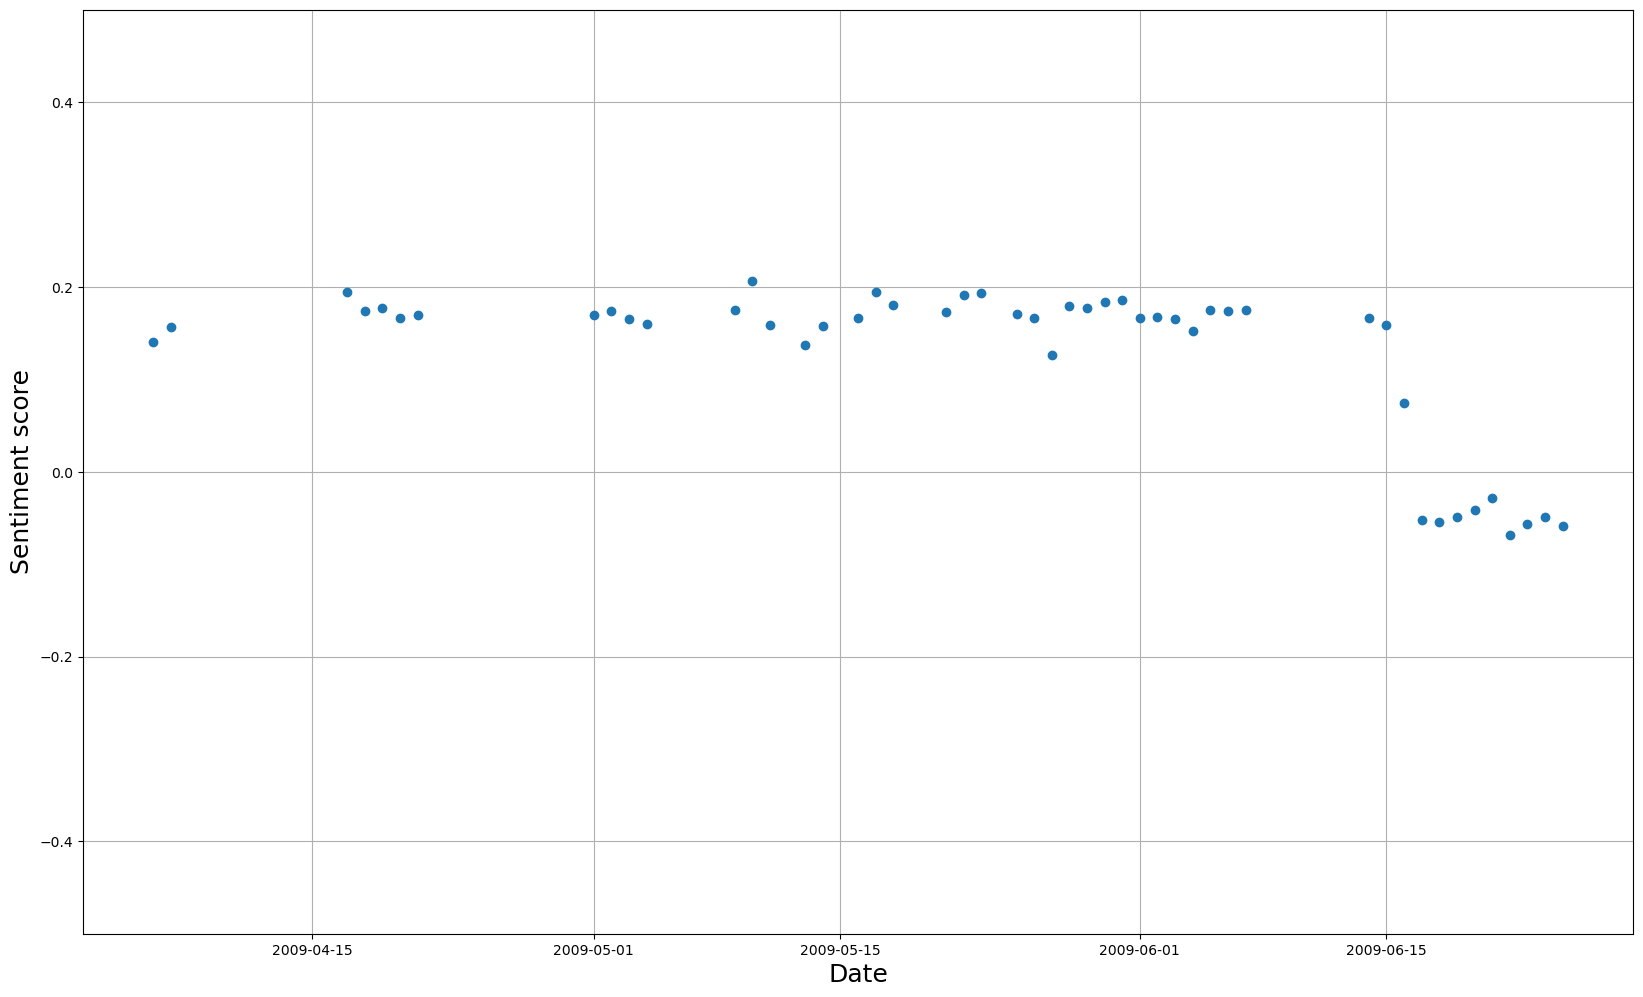

In [101]:
fig, ax=plt.subplots(figsize=(20, 12))

ax.plot(tweets_byday.Date, tweets_byday["vader_score"], linestyle="",marker="o")

plt.ylim([-.5,.5])
plt.grid()

plt.xlabel("Date", fontsize = 18)
plt.ylabel("Sentiment score", fontsize = 18)

plt.show
#data_test['y'].plot(ax=ax, label='test')
#ax.legend();

In [102]:
### Check for stationarity

In [103]:
#Below results show that the data is non-stationary

# ADF Test
result = adfuller(tweets_byday.vader_score, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(tweets_byday.vader_score, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.11838188155864314
p-value: 0.9475765681751691
Critial Values:
   1%, -3.5778480370438146
Critial Values:
   5%, -2.925338105429433
Critial Values:
   10%, -2.6007735310095064

KPSS Statistic: 0.619540
p-value: 0.020860
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


In [104]:
#Can't decompose due to the missing values
#Error returned:
    #ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a
    #DatetimeIndex with a freq not set to None

# Multiplicative Decomposition 
#result_mul = seasonal_decompose(tweets_byday['vader_score'], model='multiplicative', extrapolate_trend='freq')

# Additive Decomposition
#result_add = seasonal_decompose(tweets_byday['vader_score'], model='additive', extrapolate_trend='freq')

# Plot
#plt.rcParams.update({'figure.figsize': (10,10)})
#result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
#result_add.plot().suptitle('Additive Decompose', fontsize=22)
#plt.show()

### Impute missing dates

In [105]:
start = tweets_byday.Date[0]
end = tweets_byday.Date[len(tweets_byday)-1]

all_dates = pd.date_range(start=start,end=end,freq='D')
len(all_dates)

81

In [106]:
score_imputed = tweets_byday.copy()

In [107]:
score_imputed.set_index('Date', inplace= True)
score_imputed = score_imputed.reindex(all_dates)

#score_imputed = score_imputed.rename_axis('Date')
Dates = score_imputed.index

score_imputed.head(15)

,vader_score
2009-04-06,0.140128
2009-04-07,0.156389
2009-04-08,NaN
2009-04-09,NaN
2009-04-10,NaN
2009-04-11,NaN
2009-04-12,NaN
2009-04-13,NaN
2009-04-14,NaN
2009-04-15,NaN


In [108]:
# Format the data for KNN processing
score_imputed["month"] = score_imputed.index.month
score_imputed["day"] = score_imputed.index.day
score_imputed.reset_index(drop=True, inplace = True)

In [109]:
score_imputed.head(20)

,vader_score,month,day
0,0.140128,4,6
1,0.156389,4,7
2,NaN,4,8
3,NaN,4,9
4,NaN,4,10
5,NaN,4,11
6,NaN,4,12
7,NaN,4,13
8,NaN,4,14
9,NaN,4,15


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


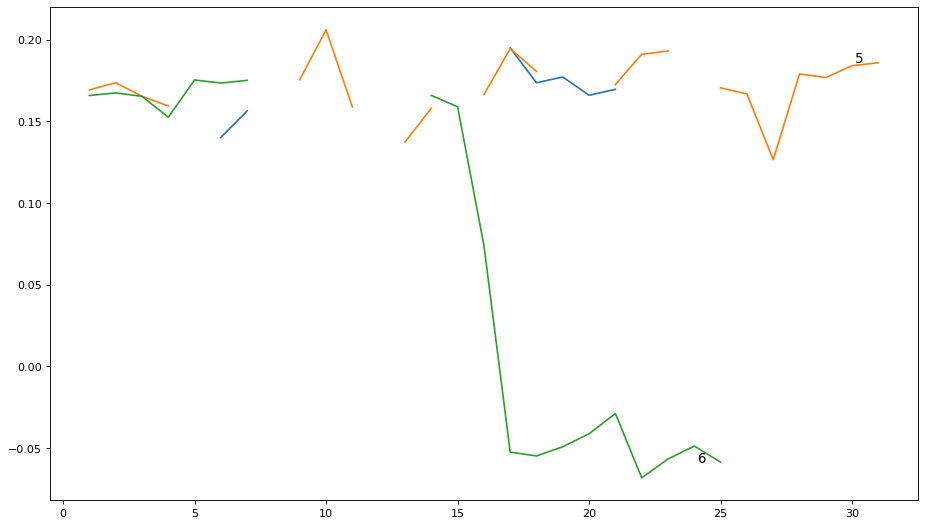

In [110]:
months = score_imputed['month'].unique()

plt.figure(figsize=(14,8), dpi= 80)
for i, y in enumerate(months):
    if i >= 0:        
        plt.plot('day', 'vader_score', data=score_imputed.loc[score_imputed.month==y, :], label=y)#, linestyle = "", marker = ".")
        plt.text(score_imputed.loc[score_imputed.month==y, :].shape[0]-.9, score_imputed.loc[score_imputed.month==y, 'vader_score'][-1:].values[0], y, fontsize=12)

### Impute missing values

In [111]:
len(tweets_byday)

48

In [112]:
#There are 33 missing values, 69% of the original dataset - too high a percentage to impute
len(score_imputed) - len(tweets_byday), (len(score_imputed) - len(tweets_byday)) / len(tweets_byday), (len(score_imputed) - len(tweets_byday)) / len(score_imputed)

(33, 0.6875, 0.4074074074074074)

In [113]:
#Score is non-parametric, so non-parametric imputation is most appropriate.
print(shapiro(tweets_byday['vader_score']))

ShapiroResult(statistic=0.6544499397277832, pvalue=2.265662102374222e-09)


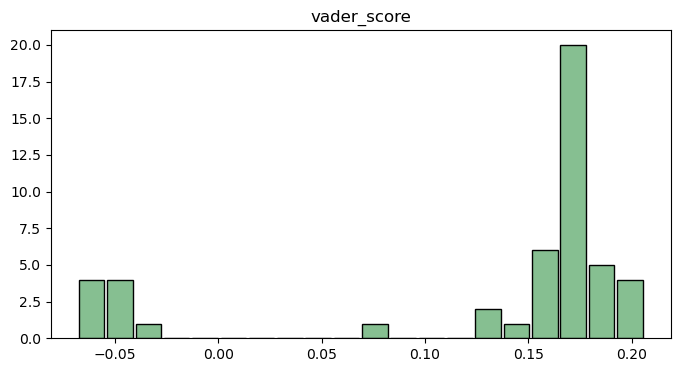

In [114]:
ax = tweets_byday.hist(column='vader_score', edgecolor='black', figsize=(8,4), bins= 20, grid=False, sharex=False, color='#86bf91', zorder=2, rwidth=0.9)

In [115]:
tweets_byday

,Date,vader_score
0,2009-04-06,0.140128
1,2009-04-07,0.156389
2,2009-04-17,0.194937
3,2009-04-18,0.173630
4,2009-04-19,0.177163
5,2009-04-20,0.165969
6,2009-04-21,0.169604
7,2009-05-01,0.169209
8,2009-05-02,0.173652
9,2009-05-03,0.165379


In [116]:
tweets_byday.set_index('Date', inplace= True)
tweets_byday.to_csv('before_imputing.csv', index=True)

In [117]:
orig_data = score_imputed.copy()
test_KNN = score_imputed.copy()

In [118]:
for i in range(2,6):
    knn_imputer = KNNImputer(n_neighbors=i)
    col_name = 'KNN_neighbours' + str(i)
    test_KNN.loc[:, col_name] = np.nan
    test_KNN[col_name] = knn_imputer.fit_transform(orig_data)

In [119]:
test_KNN

,vader_score,month,day,KNN_neighbours2,KNN_neighbours3,KNN_neighbours4,KNN_neighbours5
0,0.140128,4,6,0.140128,0.140128,0.140128,0.140128
1,0.156389,4,7,0.156389,0.156389,0.156389,0.156389
2,NaN,4,8,0.165928,0.157328,0.169503,0.170623
3,NaN,4,9,0.190748,0.179295,0.174173,0.174359
4,NaN,4,10,0.182418,0.180101,0.174173,0.166796
...,...,...,...,...,...,...,...
76,-0.028806,6,21,-0.028806,-0.028806,-0.028806,-0.028806
77,-0.068183,6,22,-0.068183,-0.068183,-0.068183,-0.068183
78,-0.056672,6,23,-0.056672,-0.056672,-0.056672,-0.056672
79,-0.048745,6,24,-0.048745,-0.048745,-0.048745,-0.048745


In [120]:
test_KNN["Date"] = Dates

In [121]:
test_KNN.head(20)

,vader_score,month,day,KNN_neighbours2,KNN_neighbours3,KNN_neighbours4,KNN_neighbours5,Date
0,0.140128,4,6,0.140128,0.140128,0.140128,0.140128,2009-04-06
1,0.156389,4,7,0.156389,0.156389,0.156389,0.156389,2009-04-07
2,NaN,4,8,0.165928,0.157328,0.169503,0.170623,2009-04-08
3,NaN,4,9,0.190748,0.179295,0.174173,0.174359,2009-04-09
4,NaN,4,10,0.182418,0.180101,0.174173,0.166796,2009-04-10
5,NaN,4,11,0.182418,0.180101,0.169398,0.167120,2009-04-11
6,NaN,4,12,0.148049,0.151369,0.165034,0.165208,2009-04-12
7,NaN,4,13,0.147650,0.151369,0.155003,0.155790,2009-04-13
8,NaN,4,14,0.147650,0.153735,0.155036,0.157293,2009-04-14
9,NaN,4,15,0.162165,0.161089,0.169551,0.150477,2009-04-15


In [122]:
test_KNN.set_index('Date', inplace= True)

In [123]:
test_KNN.drop(columns=['month', 'day'], inplace=True)

In [124]:
#save to file
test_KNN.to_csv('KNN_neighbours_select.csv', index=True)

### See dashboard to examine KNN values

2 nearest neighbours chosen as best model to fit imputedvalues

In [125]:
knn_imputer = KNNImputer(n_neighbors=2)
score_imputed['vader_score'] = knn_imputer.fit_transform(orig_data)

In [126]:
score_imputed

,vader_score,month,day
0,0.140128,4,6
1,0.156389,4,7
2,0.165928,4,8
3,0.190748,4,9
4,0.182418,4,10
...,...,...,...
76,-0.028806,6,21
77,-0.068183,6,22
78,-0.056672,6,23
79,-0.048745,6,24


In [127]:
score_imputed["Date"] = Dates
score_imputed.set_index('Date', inplace= True)

<function matplotlib.pyplot.show(close=None, block=None)>

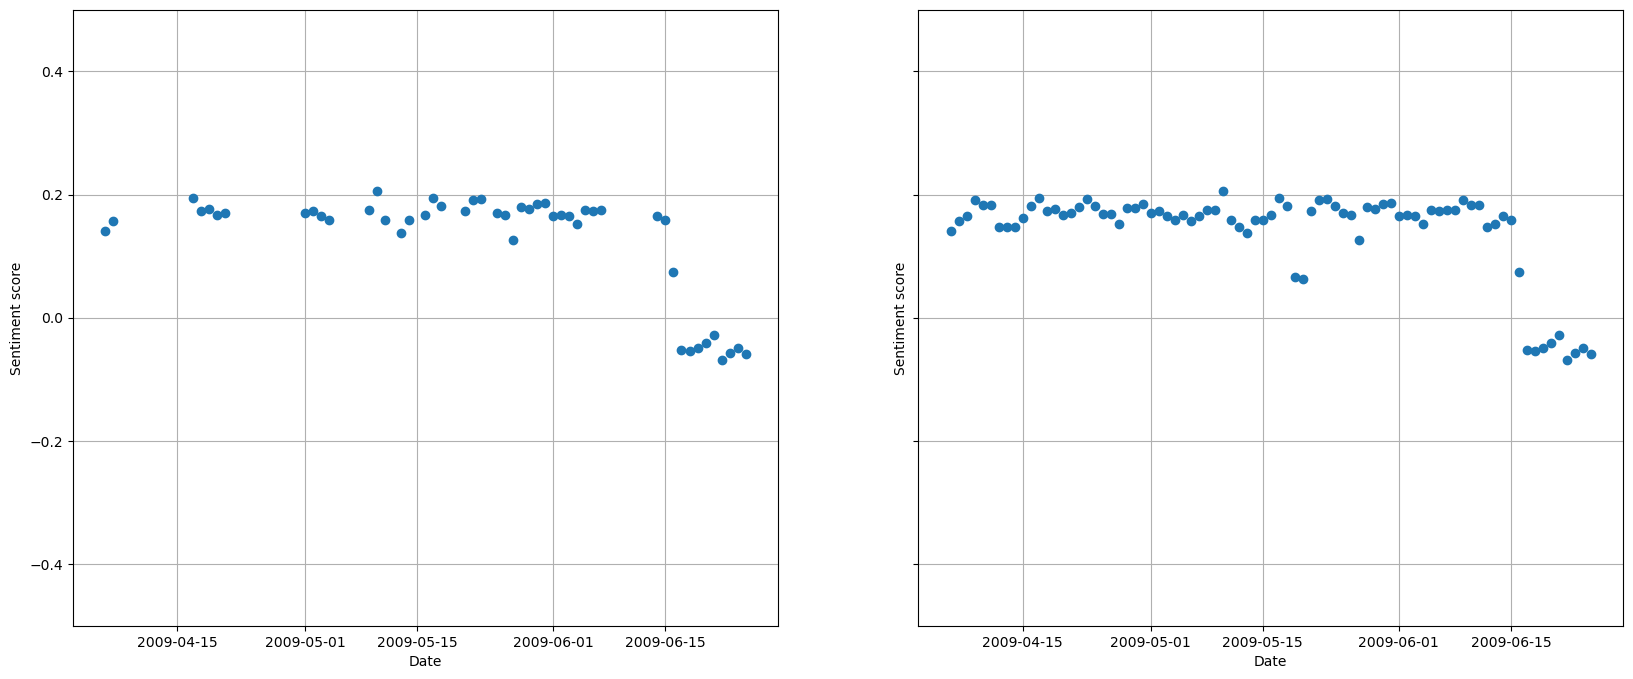

In [128]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8), sharey = True)
plt.ylim([-.5,.5])

axs[0].plot(tweets_byday.index, tweets_byday['vader_score'], linestyle="",marker="o")
axs[0].grid()

axs[1].plot(score_imputed.index, score_imputed['vader_score'], linestyle="",marker="o")
axs[1].grid()

for ax in axs.flat:
    ax.set(xlabel='Date', ylabel='Sentiment score')

plt.show

In [129]:
#Previous p-values were 0.95 and 0.02

# ADF Test
result = adfuller(score_imputed.vader_score, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

# KPSS Test
result = kpss(score_imputed.vader_score, regression='c')
print('\nKPSS Statistic: %f' % result[0])
print('p-value: %f' % result[1])
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -0.414181886434803
p-value: 0.907703846026343
Critial Values:
   1%, -3.517113604831504
Critial Values:
   5%, -2.8993754262546574
Critial Values:
   10%, -2.5869547797501644

KPSS Statistic: 0.585622
p-value: 0.023943
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


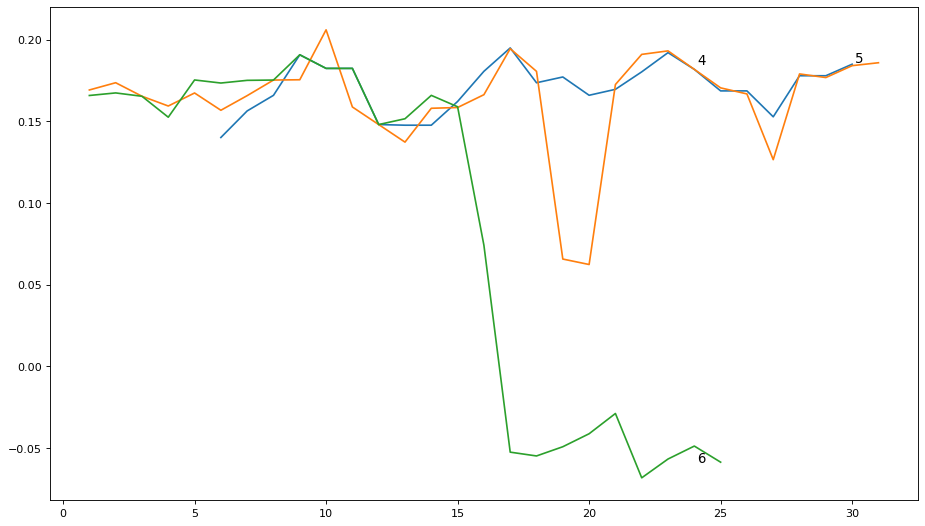

In [130]:
months = score_imputed['month'].unique()

plt.figure(figsize=(14,8), dpi= 80)
for i, y in enumerate(months):
    if i >= 0:        
        plt.plot('day', 'vader_score', data=score_imputed.loc[score_imputed.month==y, :], label=y)#, linestyle = "", marker = ".")
        plt.text(score_imputed.loc[score_imputed.month==y, :].shape[0]-.9, score_imputed.loc[score_imputed.month==y, 'vader_score'][-1:].values[0], y, fontsize=12)

In [131]:
score_imputed.drop(["month", "day"], axis = 1, inplace = True)

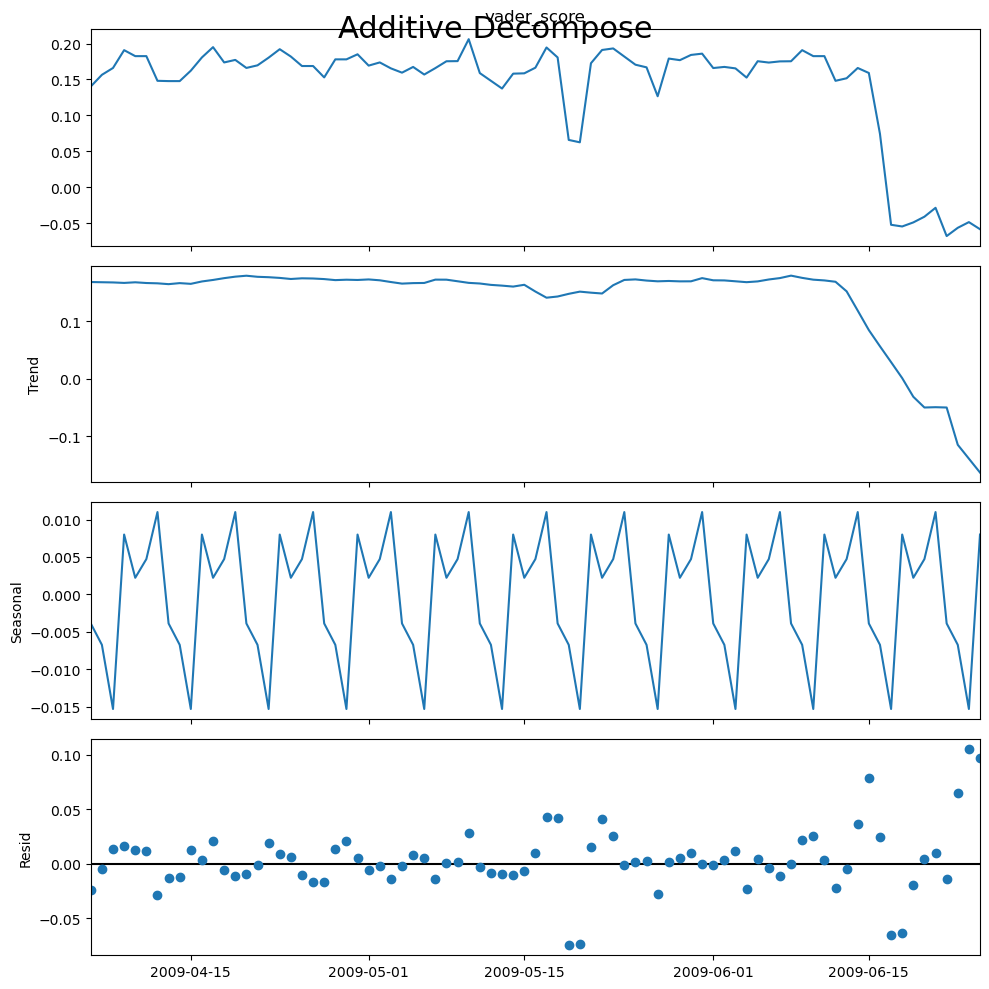

In [132]:
# Additive Decomposition
result_add = seasonal_decompose(score_imputed['vader_score'], model='additive', extrapolate_trend='freq')

#Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

In [51]:
#save to file
score_imputed.to_csv('score_imputed.csv', index=True) 

### Forecasting

#### ARIMA

Used as the data is not stationary, but has a trend.

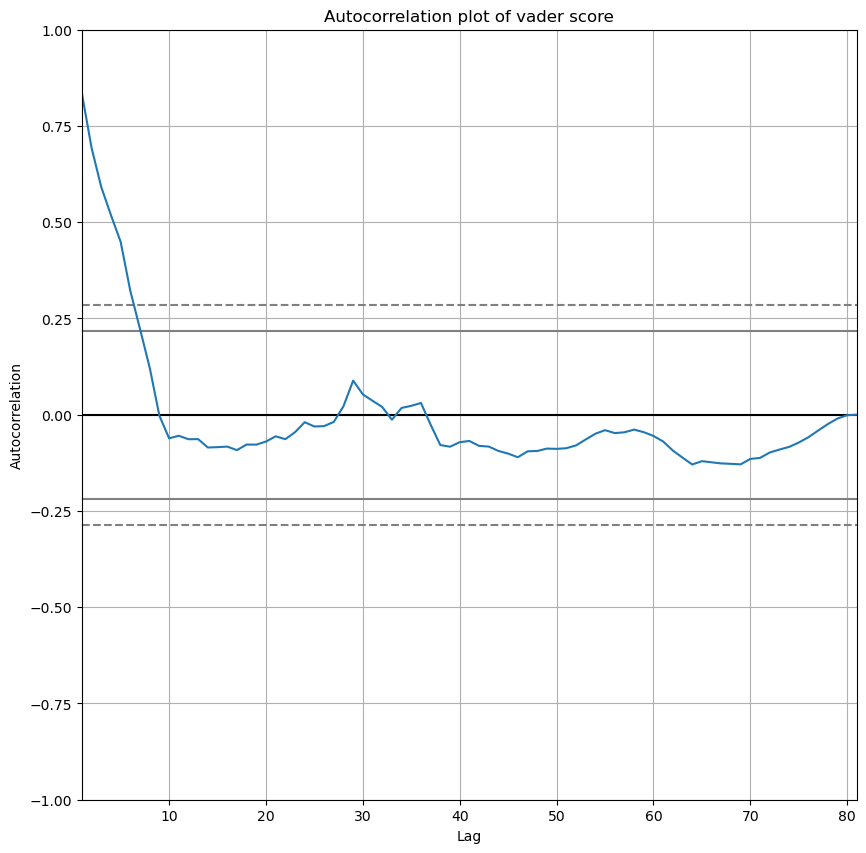

In [52]:
#As a result of the below will set p to 5 in ARIMA and SARIMA Models

autocorrelation_plot(score_imputed["vader_score"])
plt.title("Autocorrelation plot of vader score")
plt.show()

In [53]:
# 1 week, 1 month, and 3 months
pred_periods = [7, 31, 93]

In [54]:
#https://people.duke.edu/~rnau/411arim.htm

ARIMAmodel = SARIMAX(score_imputed, order = (5, 1, 1))
ARIMAmodel = ARIMAmodel.fit()

for x in range(len(pred_periods)):
    y_pred = ARIMAmodel.get_forecast(pred_periods[x])
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0],
                                              end = y_pred_df.index[-1])
    y_pred_df.index.name='Date'
    if x == 0:
        y_pred_out_week_ARIMA = y_pred_df["Predictions"]
    if x == 1:
        y_pred_out_month_ARIMA = y_pred_df["Predictions"]
    if x == 2:
        y_pred_out_3month_ARIMA = y_pred_df["Predictions"]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.95188D+00    |proj g|=  1.86724D+00

At iterate    5    f= -1.95354D+00    |proj g|=  4.49581D-01

At iterate   10    f= -1.95385D+00    |proj g|=  1.17450D-01

At iterate   15    f= -1.95736D+00    |proj g|=  4.21019D-01

At iterate   20    f= -1.95764D+00    |proj g|=  8.40741D-02

At iterate   25    f= -1.95963D+00    |proj g|=  5.32587D-01

At iterate   30    f= -1.95973D+00    |proj g|=  1.29138D-01

At iterate   35    f= -1.95982D+00    |proj g|=  2.40053D-02

At iterate   40    f= -1.95983D+00    |proj g|=  3.89572D-02

At iterate   45    f= -1.95984D+00    |proj g|=  3.27292D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


Text(0.5, 0.98, 'Sentiment score prediction ARIMA')

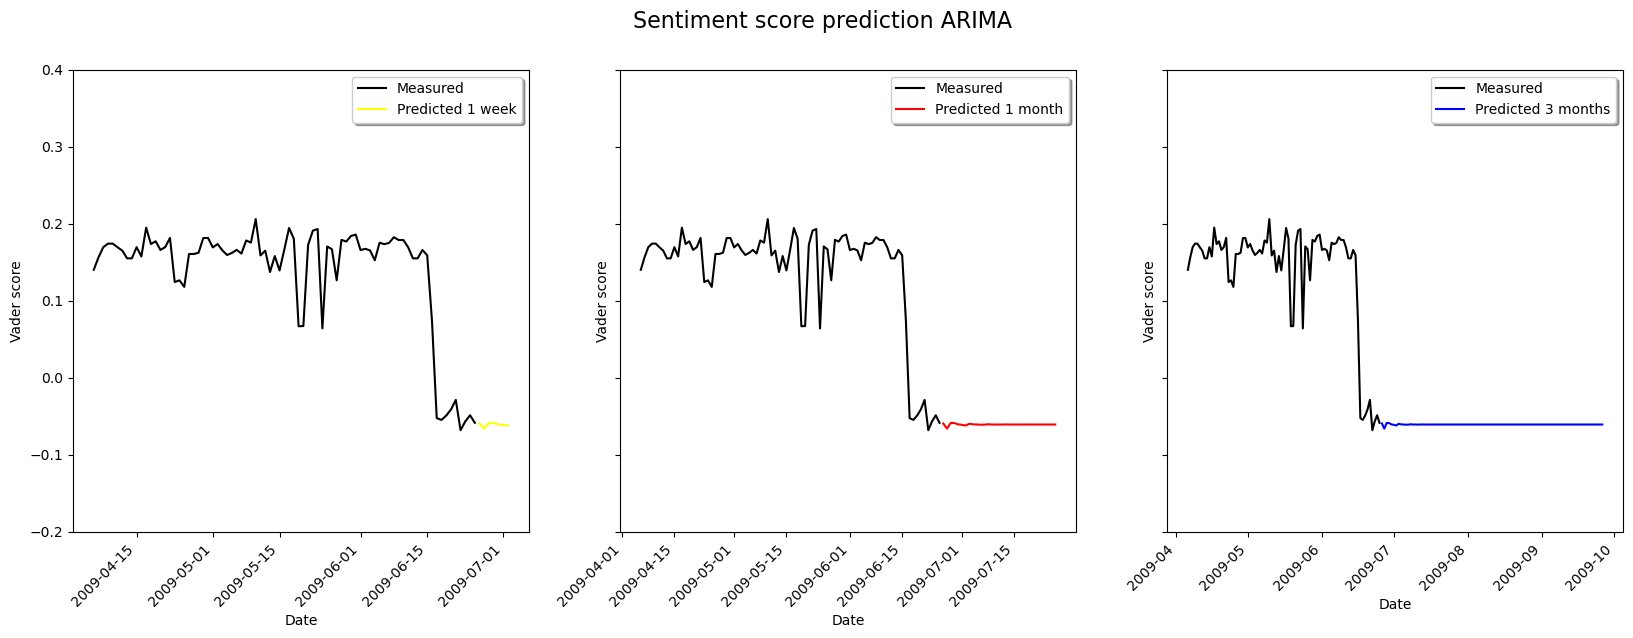

In [55]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey = True)
plt.ylim([-.2,.4])

axs[0].plot(score_imputed, color = "black", label = 'Data')
axs[0].set_ylabel('Vader score')
axs[0].set_xlabel('Date')
axs[0].plot(y_pred_out_week_ARIMA, color='Yellow', label = '1 week')
axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(), rotation=45, ha='right')
axs[0].legend(('Measured', 'Predicted 1 week'), loc='upper right', shadow=True)

axs[1].plot(score_imputed, color = "black", label = 'Data')
axs[1].set_ylabel('Vader score')
axs[1].set_xlabel('Date')
axs[1].plot(y_pred_out_month_ARIMA, color='Red', label = '1 month')
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].legend(('Measured', 'Predicted 1 month'), loc='upper right', shadow=True)

axs[2].plot(score_imputed, color = "black", label = 'Data')
axs[2].set_ylabel('Vader score')
axs[2].set_xlabel('Date')
axs[2].plot(y_pred_out_3month_ARIMA, color='Blue', label = '3 month')
axs[2].set_xticks(axs[2].get_xticks(), axs[2].get_xticklabels(), rotation=45, ha='right')
axs[2].legend(('Measured', 'Predicted 3 months'), loc='upper right', shadow=True)

fig.suptitle('Sentiment score prediction ARIMA', fontsize=16)

#### SARIMA

Used to account for both trend and seasonality

In [56]:
SARIMAmodel = SARIMAX(score_imputed, order = (5, 0, 1), seasonal_order=(5, 0, 1, 7))
SARIMAmodel = SARIMAmodel.fit()

for x in range(len(pred_periods)):
    y_pred = SARIMAmodel.get_forecast(pred_periods[x])
    y_pred_df = y_pred.conf_int(alpha = 0.05) 
    y_pred_df["Predictions"] = SARIMAmodel.predict(start = y_pred_df.index[0],
                                                end = y_pred_df.index[-1])
    y_pred_df.index.name='Date'
    if x == 0:
        y_pred_out_week_SARIMA = y_pred_df["Predictions"]
    if x == 1:
        y_pred_out_month_SARIMA = y_pred_df["Predictions"]
    if x == 2:
        y_pred_out_3month_SARIMA = y_pred_df["Predictions"]

/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.94547D+00    |proj g|=  1.06523D+00

At iterate    5    f= -1.94674D+00    |proj g|=  1.42682D+00

At iterate   10    f= -1.96172D+00    |proj g|=  4.21958D-01

At iterate   15    f= -1.96223D+00    |proj g|=  9.22062D-01

At iterate   20    f= -1.96416D+00    |proj g|=  1.45053D-01

At iterate   25    f= -1.96446D+00    |proj g|=  2.91903D-01

At iterate   30    f= -1.96501D+00    |proj g|=  2.78269D-01

At iterate   35    f= -1.96594D+00    |proj g|=  6.00404D-02

At iterate   40    f= -1.96724D+00    |proj g|=  1.19088D-01

At iterate   45    f= -1.96776D+00    |proj g|=  6.26204D-02

At iterate   50    f= -1.96957D+00    |proj g|=  1.61503D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/jacksbed/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 0.98, 'Sentiment score prediction ARIMA')

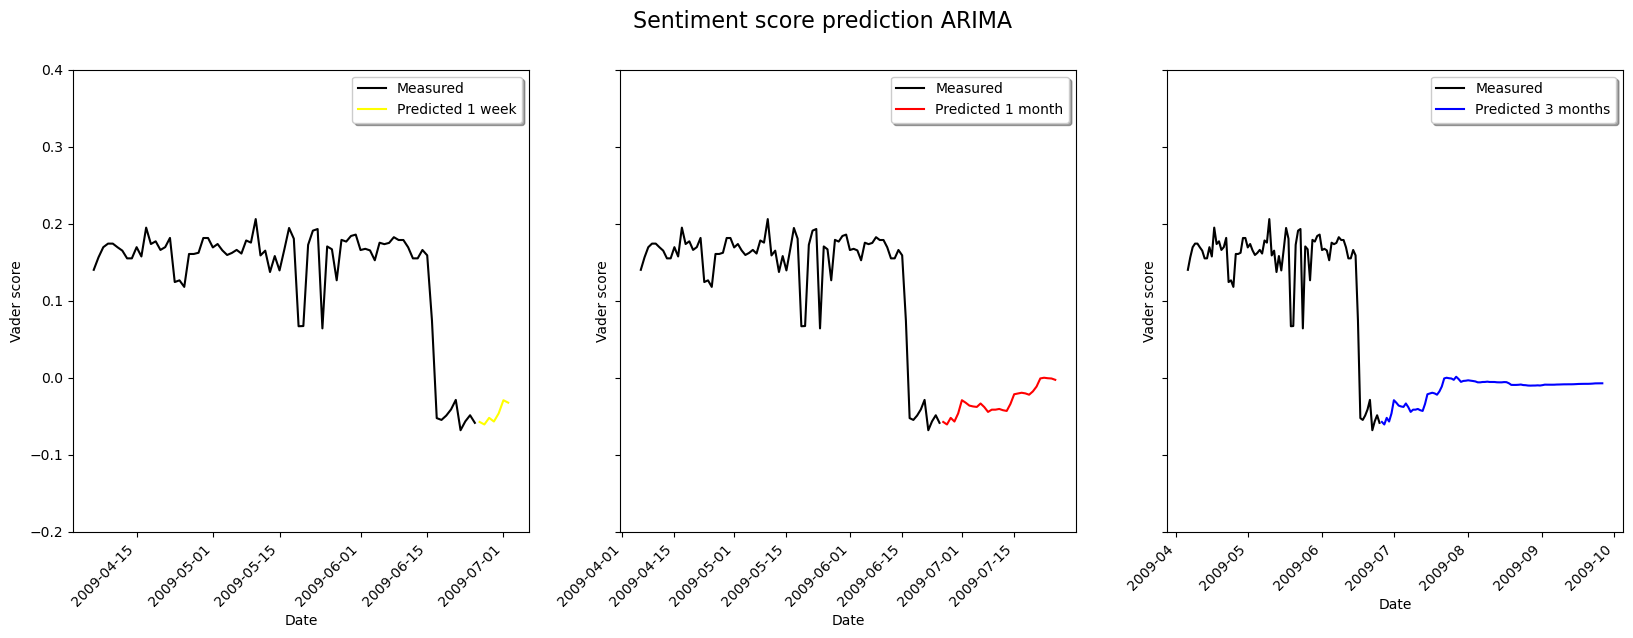

In [57]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey = True)
plt.ylim([-.2,.4])

axs[0].plot(score_imputed, color = "black", label = 'Data')
axs[0].set_ylabel('Vader score')
axs[0].set_xlabel('Date')
axs[0].plot(y_pred_out_week_SARIMA, color='Yellow', label = '1 week')
axs[0].set_xticks(axs[0].get_xticks(), axs[0].get_xticklabels(), rotation=45, ha='right')
axs[0].legend(('Measured', 'Predicted 1 week'), loc='upper right', shadow=True)

axs[1].plot(score_imputed, color = "black", label = 'Data')
axs[1].set_ylabel('Vader score')
axs[1].set_xlabel('Date')
axs[1].plot(y_pred_out_month_SARIMA, color='Red', label = '1 month')
axs[1].set_xticks(axs[1].get_xticks(), axs[1].get_xticklabels(), rotation=45, ha='right')
axs[1].legend(('Measured', 'Predicted 1 month'), loc='upper right', shadow=True)

axs[2].plot(score_imputed, color = "black", label = 'Data')
axs[2].set_ylabel('Vader score')
axs[2].set_xlabel('Date')
axs[2].plot(y_pred_out_3month_SARIMA, color='Blue', label = '3 month')
axs[2].set_xticks(axs[2].get_xticks(), axs[2].get_xticklabels(), rotation=45, ha='right')
axs[2].legend(('Measured', 'Predicted 3 months'), loc='upper right', shadow=True)

fig.suptitle('Sentiment score prediction ARIMA', fontsize=16)

In [58]:
y_pred_out_week_SARIMA.to_csv('week_prediction.csv', index=True)
y_pred_out_month_SARIMA.to_csv('month_prediction.csv', index=True)
y_pred_out_3month_SARIMA.to_csv('3month_prediction.csv', index=True)